## Generate tank bathymetry 

I still need to make into cylindrical coords.

This notebook is based on the functions *make_arbitrary_topo_smooth*, *tanktopo*, *canyontopo* and *widthprofile* which were originally written by S. Allen, and modified by T. Howatt and J. Spurgin (They have been translated form python to matlab and here to python again). 

They have to be loaded from the module BathyPythonTools.py

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

%matplotlib inline

In [2]:
import canyon_tools.bathy_tools as bat
import canyon_tools.savitzky_golay as sg

In [3]:
#Interpolating my alongshore(AS) spacing - x-direction
ASx_size = 361
x_vary=np.arange(0,ASx_size,1)


In [6]:
#What I am using for the linear part (200m spacing between 33,000 & 87000m)
ASx_linear = (0,45,315,360) # %/x_size
ASy_linear = (0,33.0e+1,87.0e+1,120.0e+1)
AS_linear = np.interp(x_vary,ASx_linear,ASy_linear) # donde quiero, donde esta, y lo que es
delx_AS_linear = (AS_linear[1:] - AS_linear[0:-1])

print (np.shape(delx_AS_linear))
#print (delx_AS_linear)


(360,)


(360,)


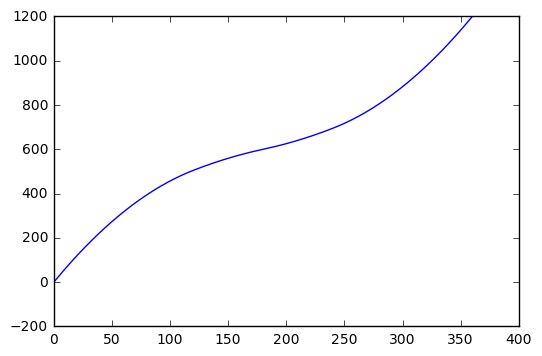

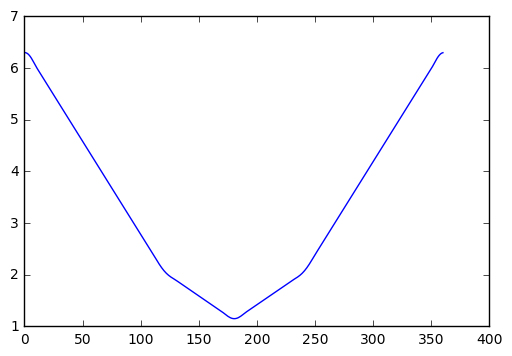

In [7]:
# x0-50 and x320-370
ASx_Boundaries = (0,120,180,240,360) #/x_size;
ASy_Boundaries = (0, 50.5e+1,60.0e+1,69.5e+1,120.0e+1)
sup_cubicL=np.arange(0,ASx_size,1)
cubfunc_x = interp1d(ASx_Boundaries,ASy_Boundaries,kind='quadratic', bounds_error=False) # bound_error=False allows values outside the domain to get NaN's
AS_Boundaries = cubfunc_x(x_vary) 
AS_BoundariesFilt=sg.savitzky_golay(AS_Boundaries, 21, 3) 

delx_AS_Boundaries = (AS_BoundariesFilt[1:] - AS_BoundariesFilt[0:-1]);


print (np.shape(delx_AS_Boundaries))
#print (delx_AS_Left)
plt.plot(x_vary,AS_BoundariesFilt)
plt.show()
plt.plot(x_vary[1:],delx_AS_Boundaries)
plt.show()

(360,)
(360,)
(361,)
[ 6.29819822  6.29050708  6.27536036  6.25322918  6.22482024  6.1910758
  6.15317366  6.1125272   6.07078538  6.02983269  5.99178922  5.9557598
  5.91973039  5.88370098  5.84767157  5.81164216  5.77561275  5.73958333
  5.70355392  5.66752451  5.6314951   5.59546569  5.55943627  5.52340686
  5.48737745  5.45134804  5.41531863  5.37928922  5.3432598   5.30723039
  5.27120098  5.23517157  5.19914216  5.16311275  5.12708333  5.09105392
  5.05502451  5.0189951   4.98296569  4.94693627  4.91090686  4.87487745
  4.83884804  4.80281863  4.76678922  4.7307598   4.69473039  4.65870098
  4.62267157  4.58664216  4.55061275  4.51458333  4.47855392  4.44252451
  4.4064951   4.37046569  4.33443627  4.29840686  4.26237745  4.22634804
  4.19031863  4.15428922  4.1182598   4.08223039  4.04620098  4.01017157
  3.97414216  3.93811275  3.90208333  3.86605392  3.83002451  3.7939951
  3.75796569  3.72193627  3.68590686  3.64987745  3.61384804  3.57781863
  3.54178922  3.5057598   3.46973

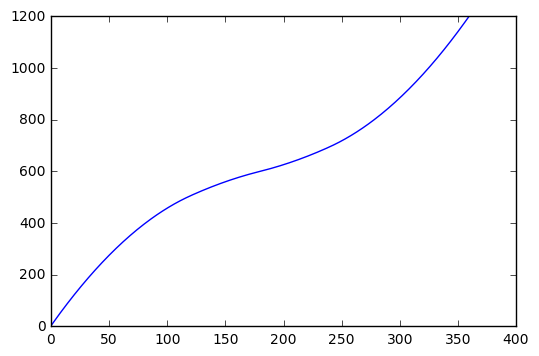

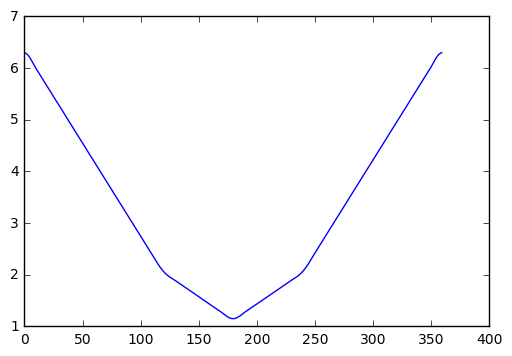

In [8]:
x_edge = np.zeros(361)

x_edge = AS_BoundariesFilt
#x_edge[315:] = AS_Boundaries[315:]
#x_edge[45:315] = AS_linear[45:315]

x = ((x_edge[1:] + x_edge[0:-1])/2)
delx = (x_edge[1:] - x_edge[0:-1])

print (np.shape(delx))
print (np.shape(x))
print (np.shape(x_edge))
print (delx)
plt.plot(x)
plt.show()
plt.plot(delx)


In [9]:
# The cross-shore (CS) variation - y-direction

CSy_size = 361
y_vary = np.arange(0,CSy_size,1)

In [10]:
#What I am using for the linear part

CSx_linear = (0,20,340,360)
CSy_linear = (0,10.0e+1,80.0e+1,90.0e+1)
CS_linear = np.interp(y_vary,CSx_linear,CSy_linear)
dely_CS_linear = (CS_linear[1:] - CS_linear[0:-1])

print (np.shape(dely_CS_linear))
#print (dely_CS_linear)


(360,)


(360,)


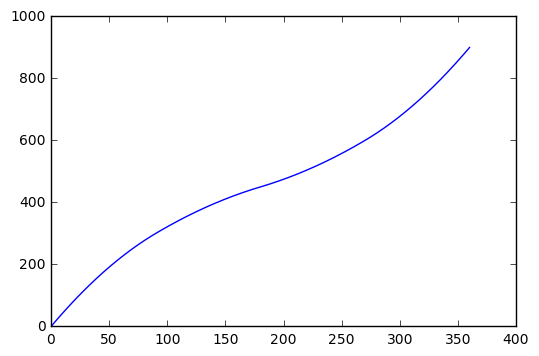

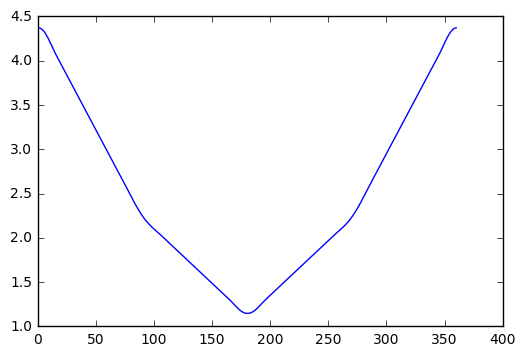

In [11]:
#What I am currently using for x0-40 and x340-360
CSx_Boundaries = (0,90,180,270,360)
CSy_Boundaries = (0,30.0e+1,45.0e+1,60.0e+1,90.0e+1)
cubfunc_y = interp1d(CSx_Boundaries,CSy_Boundaries,kind='quadratic', bounds_error=False)
CS_Boundaries = cubfunc_y(y_vary)

CS_BoundariesFilt=sg.savitzky_golay(CS_Boundaries, 31, 3) 
dely_CS_Boundaries = (CS_BoundariesFilt[1:] - CS_BoundariesFilt[0:-1])

print (np.shape(dely_CS_Boundaries))


plt.plot(y_vary,CS_Boundaries)
plt.show()
plt.plot(y_vary[1:],dely_CS_Boundaries)


(360,)
(360,)
(361,)


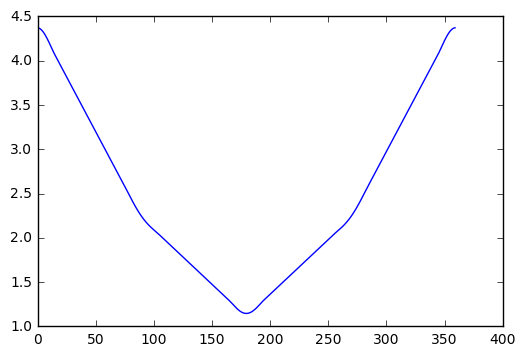

In [12]:

x_edge = AS_BoundariesFilt
y_edge = np.zeros(361)

y_edge=CS_BoundariesFilt

y = ((y_edge[1:] + y_edge[0:-1])/2)
dely = (y_edge[1:] - y_edge[0:-1])

print (np.shape(dely))
print (np.shape(y))
print (np.shape(y_edge))


#plt.plot(y)
plt.plot(dely)



In [13]:
total_fluid_depth = 12.0


###############################################################################
### Barkley Canyon -like ###
y_base = 25950.0  
y_bc = 26360.0
y_sb = 0.225
y_100 = 56130.0
y_50 = 64220.0
y_wall = 0.50
y_coast = 0.50

z_bottom = 100.0 
z_sb = 1050.0 
z_100 = 1100.0 
z_wall = 1180.0
z_bc = 200.0
z_50 = 1150.0
z_200 = 1000.0
z_400 = 800.0
z_600 = 600.0
z_800 = 400.0


x_wall = 120000.0
cR = 5000.0        # radius of curvature on upstream side
W = 8300.0     # canyon width at half-length
Wsb = 13000.0   # canyon width at shelf-break 
L = 6400.0       # canyon length


#####
#set geometric parameters (see geometry.ods)
p = 4.0                    # saved as geometry.csv        
q = 6.0
# Constant buoyancy frequency
N = 0.004


# Grid size in x and y
x_size = 360
y_size = 360


d = bat.make_arbitrary_topo_smooth(total_fluid_depth,cR,W,Wsb,L,p,x,x_wall,y_edge,y_base,y_bc,y_sb,y_coast,z_bottom,z_bc,z_sb,z_wall)

print(d.shape)

d[:,CSy_size-1]=0

bathy=d[:,0:-1]

print(bathy.shape)



(360, 361)
(360, 360)


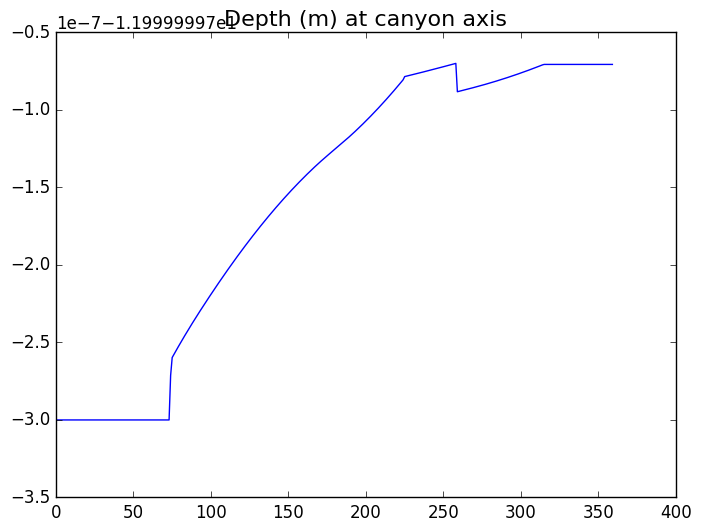

In [14]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(8,6))

CS = plt.plot(bathy[180,:] )

plt.title('Depth (m) at canyon axis',fontsize=16)

In [15]:
## Extend downstream shelf
nx_ext = 616
ny = 360

bathy_ext = np.empty((nx_ext,ny))
delx_ext = np.empty(nx_ext)

bathy_ext[:360,:]=bathy
delx_ext[0:360]=delx

bathy_ext[360:,:]=bathy[359,:]
delx_ext[360:]=630

x_ext = np.zeros(len(delx_ext))
for ii in range(1,len(delx_ext)):
    x_ext[ii] = x_ext[ii-1]+delx_ext[ii]


<function matplotlib.pyplot.show>

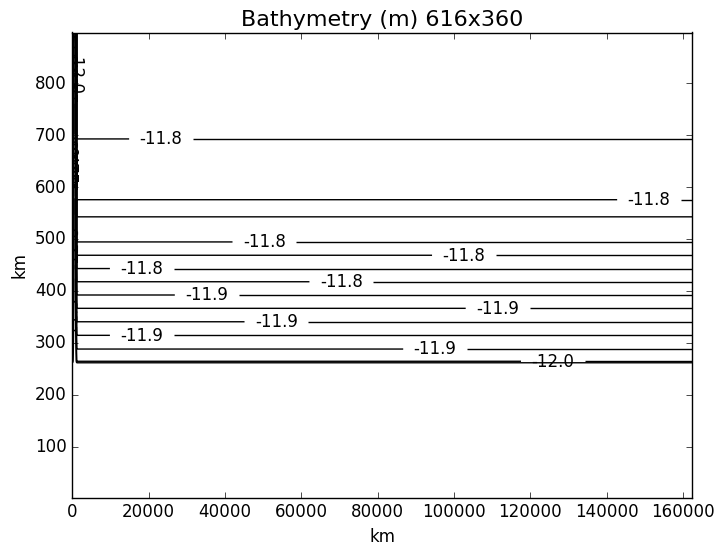

In [16]:
plt.rcParams['contour.negative_linestyle'] = 'solid'

fig = plt.figure(figsize=(8,6))

CS = plt.contour(x_ext,y,np.transpose(bathy_ext),15,colors='k' )

plt.clabel(CS, 
           inline=1,
           fmt='%1.1f',
           fontsize=12)

plt.xlabel('km')
plt.ylabel('km')
plt.title('Bathymetry (m) 616x360',fontsize=16)



plt.show


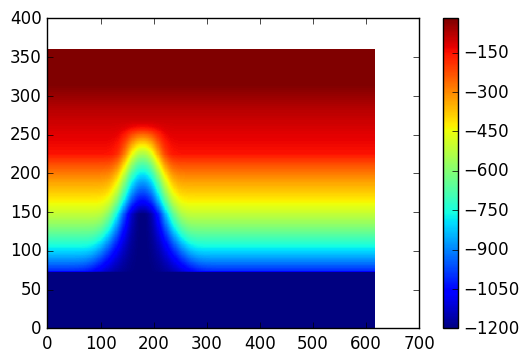

In [24]:
# saving binary files

dt = np.dtype('>f8')  # float 64 big endian

tmpfile = "dely_%dx%d_NonUni_BarkleyLikeQuadExt.bin" %(nx_ext,360)
fileobj = open(tmpfile,mode='wb')
dely.astype(dt).tofile(fileobj,"")
fileobj.close()

tmpfile = "delx_%dx%d_NonUni_BarkleyLikeQuadExt.bin" %(nx_ext,360)
fileobj = open(tmpfile, mode='wb')
delx_ext.astype(dt).tofile(fileobj,"")
fileobj.close()

tmpfile = "bathy_smooth_%dx%d_NonUni_BarkleyLikeQuadExt.bin"%(nx_ext,360)
fileobj = open(tmpfile, mode='wb')
dd=np.transpose(bathy_ext)
#dd=np.asfortranarray(bathy, dtype=dt)
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

plt.pcolor(dd)
plt.colorbar()


In [25]:
#Check that it works when read by Fortran

filename = 'bathy_smooth_%dx%d_NonUni_BarkleyLikeQuadExt.bin'%(nx_ext,360)
cc=np.fromfile(filename, dtype=dt)
np.shape(cc)



(221760,)

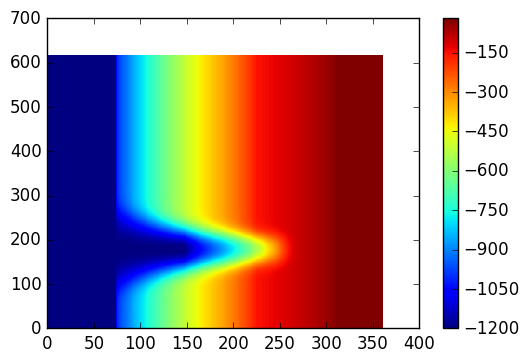

In [26]:

bF=np.reshape(cc,[nx_ext,360],'F') # F to read in Fortran order
plt.pcolor(bF)
plt.colorbar()

In [27]:
x_ext[nx_ext-1]

280650.18017790635

 Parameter definitions:
 --------------------
 
  y_wall = the length of the ocean basin (y-axis)(going from 0=deep ocean m high values = coast
  x_wall = the width of the ocean basin (x-axis)
  y_base = the distance where the slope begins to rise from the bottom
   y_bc = the distance to the canyon mouth
   y_sb = the distance of the shelf break
   y_100 = the distance to the 100m isobath
   y_50 = the distance to the 50m isobath
 y_coast = the distance to the "coast" where topography stops increasing, but depth NOT =0
z_bottom = depth of the "deep ocean"; z is measured from the bottom up
  z_bc = depth of the 1000 m contour
  z_800 = depth of the 800 m contour
  z_600 = depth of the 600 m contour
  z_400 = depth of the 400 m contour
  z_200 = depth of the 200 m contour
   z_sb = shelf break depth (150m)
  z_100 = depth of the 100 m contour
   z50 = depth of the 50 m contour
  z_wall = the depth of the topography beyond the y_coast variable (i.e. z_wall NOT = total fluid depth)
  cR = the radius of curvature at the shelf break depth
   W = the width at half the length at the shelf break depth
   Wsb = the width at the shelf break
   L = the length of the canyon
   p,q = geometric parameters used to help shape the canyon see geometry.ods

